In [1]:
#preliminary imports
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt 
import numpy as np 
import time
from tensorflow.keras import layers
import cv2

#for gif generation
import imageio

In [2]:
#create dataset from ./training_data/
#first define some parameters:
#first start at 50 per batch, then move up

BATCH_SIZE = 50
IMG_WIDTH = 128
IMG_HEIGHT = 128

train_dir = r'./test_data/'

In [3]:
#create the training dataset
#note that we do not use validation here since validation comes from the classifier, so all images are used for training here

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = None
)

Found 1218 files belonging to 1 classes.


In [4]:
#check to see if the shape of the training data is correct
for image_batch in train_ds:
  print(image_batch.shape)
  print(image_batch)
  break

(50, 128, 128, 3)
tf.Tensor(
[[[[ 53.  52.  48.]
   [ 39.  38.  34.]
   [ 56.  55.  51.]
   ...
   [ 43.  44.  39.]
   [ 45.  46.  41.]
   [ 48.  49.  44.]]

  [[ 50.  49.  45.]
   [ 52.  51.  47.]
   [ 47.  46.  42.]
   ...
   [ 43.  44.  39.]
   [ 45.  46.  41.]
   [ 48.  49.  44.]]

  [[ 44.  45.  40.]
   [ 55.  56.  51.]
   [ 37.  38.  33.]
   ...
   [ 43.  44.  39.]
   [ 45.  46.  41.]
   [ 48.  49.  44.]]

  ...

  [[ 47.  48.  43.]
   [ 46.  47.  42.]
   [ 46.  47.  42.]
   ...
   [ 47.  48.  43.]
   [ 48.  49.  44.]
   [ 49.  50.  45.]]

  [[ 47.  48.  43.]
   [ 46.  47.  42.]
   [ 46.  47.  42.]
   ...
   [ 47.  48.  43.]
   [ 48.  49.  44.]
   [ 49.  50.  45.]]

  [[ 47.  48.  43.]
   [ 46.  47.  42.]
   [ 46.  47.  42.]
   ...
   [ 47.  48.  43.]
   [ 48.  49.  44.]
   [ 49.  50.  45.]]]


 [[[115. 131. 130.]
   [128. 140. 140.]
   [152. 156. 159.]
   ...
   [158. 190. 201.]
   [166. 194. 206.]
   [191. 217. 230.]]

  [[126. 138. 138.]
   [123. 131. 133.]
   [119. 118. 123.]

In [5]:
#normalize the rgb data to be [0 - 1]
train_ds = train_ds.map(lambda x: (x / 127.5) - 1)

for image_batch in train_ds:
  print(image_batch.shape)
  print(image_batch)
  break

(50, 128, 128, 3)
tf.Tensor(
[[[[ 0.00392163 -0.00392157 -0.654902  ]
   [ 0.01176476  0.00392163 -0.64705884]
   [ 0.01176476  0.00392163 -0.64705884]
   ...
   [ 0.30980396  0.32549024 -0.46666664]
   [ 0.30980396  0.32549024 -0.46666664]
   [ 0.30980396  0.32549024 -0.46666664]]

  [[ 0.27843142  0.27843142 -0.41176468]
   [ 0.27843142  0.27843142 -0.41176468]
   [ 0.28627455  0.28627455 -0.40392154]
   ...
   [ 0.30196083  0.3176471  -0.47450978]
   [ 0.30196083  0.3176471  -0.47450978]
   [ 0.30196083  0.3176471  -0.47450978]]

  [[ 0.2941177   0.28627455 -0.44313723]
   [ 0.2941177   0.28627455 -0.44313723]
   [ 0.30196083  0.2941177  -0.4352941 ]
   ...
   [ 0.2941177   0.30980396 -0.4823529 ]
   [ 0.2941177   0.30980396 -0.4823529 ]
   [ 0.2941177   0.30980396 -0.4823529 ]]

  ...

  [[ 0.37254906  0.33333337 -0.67058825]
   [ 0.37254906  0.33333337 -0.67058825]
   [ 0.37254906  0.33333337 -0.67058825]
   ...
   [ 0.36470592  0.3411765  -0.5764706 ]
   [ 0.37254906  0.34901965 

In [6]:
#create the generator model
def make_generator():
    model = tf.keras.Sequential()
    #first dense layer
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)
    #2nd layer -- downsample filters from 256 -> 128
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #3rd layer -- increase resolution to 16x16 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #4th layer -- increase resolution to 32x32 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #5th layer -- increase resolution to 64x64 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #6th layer -- increase resolution to 128x128 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #Final layer -- conv2d to 3 filters(RGB)
    model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    assert model.output_shape == (None, 128, 128, 3)
    return model

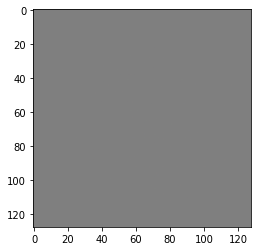

In [7]:
#generate an image
generator = make_generator()

noise = tf.random.normal([1, 100])
image = generator(noise, training=False)
image = (image + 1) / 2.0

plt.imshow(image[0,:,:,:])

In [8]:
#CNN based discriminator
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


In [9]:
#classify our generated image
discriminator = make_discriminator()
decision = discriminator(image)
print(decision)

tf.Tensor([[0.04636339]], shape=(1, 1), dtype=float32)


In [10]:
#discriminator loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def disc_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
#checkpoint setup
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
#training step
@tf.function
def train_step(images):
    #print(images.shape)

    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        generator_loss = gen_loss(fake_output)
        discrimiator_loss = disc_loss(real_output, fake_output)

        gen_gradients = gen_tape.gradient(generator_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(discrimiator_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print("Epoch " + str(epoch) + " started")
    start = time.time()

    batch = 1
    for image_batch in dataset:
        
        #print("Batch " + str(batch) + " started")
        #print(image_batch.shape)
        train_step(image_batch)

        
        #print("Batch " + str(batch) + " finished")
        batch += 1

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  predictions = (predictions + 1) / 2.0

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('./generated_images/image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()

In [16]:
train(train_ds, EPOCHS)

Epoch 0 started
Time for epoch 1 is 20.00649881362915 sec
Epoch 1 started
Time for epoch 2 is 13.63751769065857 sec
Epoch 2 started
Time for epoch 3 is 13.772008180618286 sec
Epoch 3 started
Time for epoch 4 is 13.78901720046997 sec
Epoch 4 started
Time for epoch 5 is 13.95397686958313 sec
Epoch 5 started
Time for epoch 6 is 13.837007999420166 sec
Epoch 6 started
Time for epoch 7 is 13.820016860961914 sec
Epoch 7 started
Time for epoch 8 is 14.091983795166016 sec
Epoch 8 started
Time for epoch 9 is 13.899612188339233 sec
Epoch 9 started
Time for epoch 10 is 13.977969408035278 sec
Epoch 10 started
Time for epoch 11 is 14.006999492645264 sec
Epoch 11 started
Time for epoch 12 is 14.053001642227173 sec
Epoch 12 started
Time for epoch 13 is 14.152026176452637 sec
Epoch 13 started
Time for epoch 14 is 14.08899998664856 sec
Epoch 14 started
Time for epoch 15 is 14.503973722457886 sec
Epoch 15 started
Time for epoch 16 is 14.193999290466309 sec
Epoch 16 started
Time for epoch 17 is 14.3369932

KeyboardInterrupt: 

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('./generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)